In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Install Libraries and Modules

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [3]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 12.5 MB/s eta 0:00:0000:0100:01


In [4]:
import wandb

In [5]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [7]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [9]:
import os

path = '/kaggle/input'
print(os.listdir(path))


['public_data_test']


In [12]:
train_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/train/afr.csv")
train_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/train/arq.csv")
train_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/train/hin.csv")
train_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/train/swe.csv")


dev_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/afr.csv")
dev_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/arq.csv")
dev_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/hin.csv")
dev_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/swe.csv")


test_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/test/afr.csv")
test_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/test/arq.csv")
test_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/test/hin.csv")
test_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/test/swe.csv")

# AFRIKAANS

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [13]:
train_afr.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_train_track_a_00001,Die grondeienaars het die departement genader ...,0,0,0,0,0
1,afr_train_track_a_00002,Dit is verder 'n erkende feit dat daar menings...,0,0,0,0,0
2,afr_train_track_a_00003,Baie families in die Wes-Kaap is in rou gedomp...,0,0,0,0,1
3,afr_train_track_a_00004,Ons wil u deelmaak van die werk wat ons doen.,0,0,0,1,0
4,afr_train_track_a_00005,En dit onderstreep waarom NALN en NELM gesamen...,0,0,0,1,0


In [14]:
train_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1222 non-null   object
 1   text     1222 non-null   object
 2   anger    1222 non-null   int64 
 3   disgust  1222 non-null   int64 
 4   fear     1222 non-null   int64 
 5   joy      1222 non-null   int64 
 6   sadness  1222 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 67.0+ KB


In [15]:
dev_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98 non-null     object
 1   text     98 non-null     object
 2   anger    98 non-null     int64 
 3   disgust  98 non-null     int64 
 4   fear     98 non-null     int64 
 5   joy      98 non-null     int64 
 6   sadness  98 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 5.5+ KB


<Axes: >

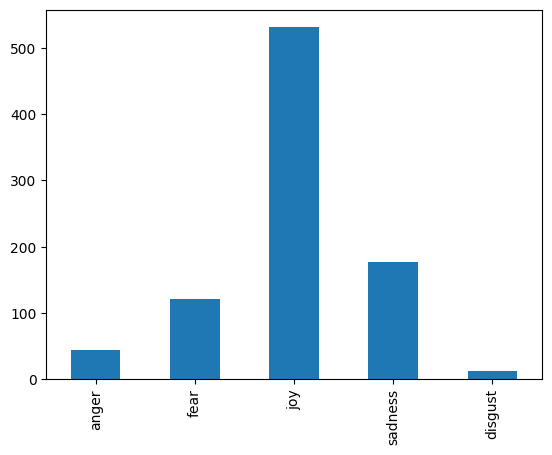

In [16]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust']
train_afr[attributes].sum().plot.bar()

<Axes: >

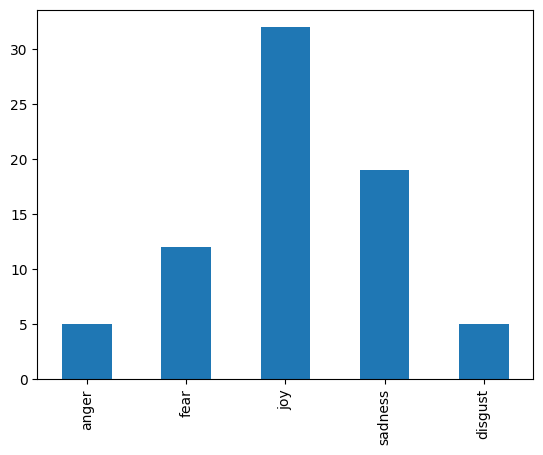

In [17]:
dev_afr[attributes].sum().plot.bar()

In [18]:
test_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1065 non-null   object 
 1   text     1065 non-null   object 
 2   anger    0 non-null      float64
 3   disgust  0 non-null      float64
 4   fear     0 non-null      float64
 5   joy      0 non-null      float64
 6   sadness  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 58.4+ KB


In [19]:
test_afr.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_test_track_a_00001,As regering is ons daartoe verbind om ons deel...,NaN,NaN,NaN,NaN,NaN
1,afr_test_track_a_00002,Op die oomblik is die kwessie van voedselsekur...,NaN,NaN,NaN,NaN,NaN
2,afr_test_track_a_00003,Ek hoor dikwels mense sê hulle is gereed om be...,NaN,NaN,NaN,NaN,NaN
3,afr_test_track_a_00004,Hiervan bly kindermishandeling waarskynlik een...,NaN,NaN,NaN,NaN,NaN
4,afr_test_track_a_00005,So gaan ons ernstig kyk na die kwaliteit van o...,NaN,NaN,NaN,NaN,NaN


https://huggingface.co/FacebookAI/xlm-roberta-base

In [20]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness"]

In [21]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none"  
)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,184,261 || all params: 279,231,754 || trainable%: 0.4241
None


In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

In [ ]:
def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness']].fillna(0).values
    return encodings, labels

In [26]:
train_encodings, train_labels = encode_data(train_afr, tokenizer)
dev_encodings, dev_labels = encode_data(dev_afr, tokenizer)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [28]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [29]:
train_dataset

In [30]:
train_dataset.encodings

{'input_ids': [[0, 622, 27006, 101682, 62538, 225, 68, 147407, 151208, 42, 171, 43039, 4, 3829, 76, 68, 57169, 22627, 22475, 13, 131, 68, 68, 624, 35208, 13, 36469, 134018, 22, 3283, 133, 297, 509, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 3011, 83, 15461, 242, 19, 72, 24700, 39237, 607, 4148, 129537, 814, 58675, 1600, 20677, 98230, 68, 493, 13728, 6048, 131, 158836, 10901, 67, 23, 16645, 9, 20671, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 64108, 87143, 23, 68, 1401, 7, 9, 146069, 83, 23, 22629, 700, 246, 31653, 22, 8953, 10686, 87143, 225, 2341, 237, 293, 9018, 12472, 664, 68, 25051, 32372, 20677, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 13417, 3562, 75, 15222, 36524, 131, 68, 5697, 793, 1260, 4977, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 357, 854, 3932, 5967, 4517, 59696, 3076, 81795, 22, 9960, 37150, 18774, 11533, 597, 22, 261, 98360, 597, 24

In [ ]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

train_lengths = calculate_token_lengths(train_afr['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_afr['text'], tokenizer)
test_lengths = calculate_token_lengths(test_afr['text'], tokenizer)

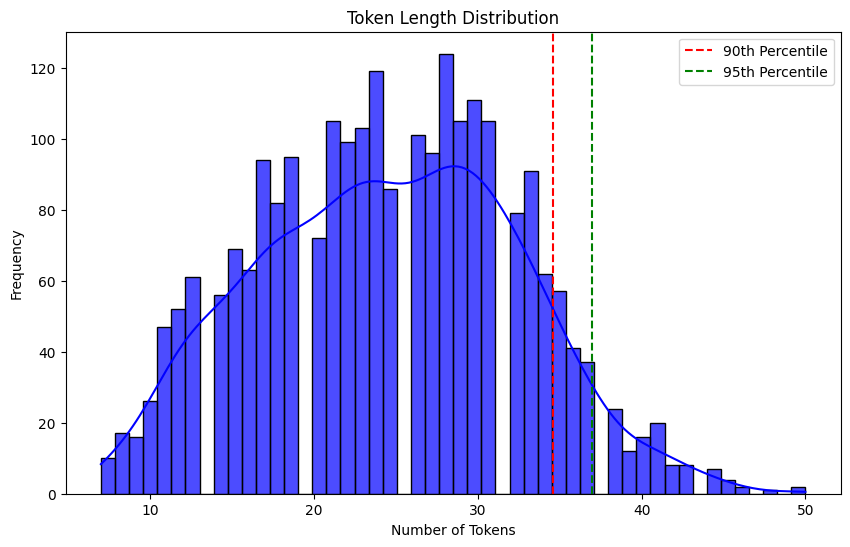

In [ ]:
all_lengths = train_lengths + dev_lengths + test_lengths

plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [33]:
from transformers import EarlyStoppingCallback

In [ ]:
def compute_metrics(pred, threshold=0.3):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > threshold).numpy()
    labels = labels.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/afr/xlm-roberta-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="f1"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [36]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.00001  
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [38]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [39]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.286900,0.305765,0.530612,0.540886,0.492939,0.657534
1000,0.263900,0.291804,0.520408,0.541623,0.475666,0.643836
1500,0.252500,0.290253,0.469388,0.530643,0.441314,0.671233
2000,0.234300,0.283598,0.520408,0.538528,0.470607,0.630137
2500,0.229400,0.284479,0.520408,0.565649,0.501335,0.671233
3000,0.221800,0.284896,0.500000,0.565161,0.486555,0.684932
3500,0.215200,0.284312,0.520408,0.557698,0.488875,0.657534
4000,0.200600,0.285712,0.540816,0.588004,0.511254,0.698630
4500,0.201300,0.285952,0.520408,0.581746,0.509781,0.684932
5000,0.194200,0.286549,0.540816,0.588696,0.512600,0.698630


In [ ]:
def find_best_threshold(pred, thresholds):
    best_threshold = 0.5
    best_f1 = 0

    for t in thresholds:
        metrics = compute_metrics(pred, threshold=t)
        print(f"metrics: {metrics}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t

    return best_threshold, best_f1

In [ ]:
def evaluate_on_validation_set(trainer, threshold_range=np.linspace(0.1, 0.9, 9)):
    predictions, labels, _ = trainer.predict(dev_dataset)  
    pred = (predictions, labels)

    best_threshold, best_f1 = find_best_threshold(pred, thresholds=threshold_range)
    print("----------------------------------------------")
    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")
    print("***********************************************")
    final_metrics = compute_metrics(pred, threshold=best_threshold)
    print(f"Metrics with Best Threshold: {final_metrics}")

    return best_threshold, final_metrics

In [42]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.3877551020408163, 'f1': 0.564023079032013, 'precision': 0.4323241760740024, 'recall': 0.8356164383561644}
metrics: {'accuracy': 0.45918367346938777, 'f1': 0.5577965607694549, 'precision': 0.46020874103065884, 'recall': 0.7123287671232876}
metrics: {'accuracy': 0.5612244897959183, 'f1': 0.5988653659886537, 'precision': 0.5202084065097764, 'recall': 0.7123287671232876}
metrics: {'accuracy': 0.5714285714285714, 'f1': 0.5271586754069355, 'precision': 0.4867803429447266, 'recall': 0.5753424657534246}
metrics: {'accuracy': 0.5816326530612245, 'f1': 0.532526833896697, 'precision': 0.5339779747515445, 'recall': 0.5342465753424658}
metrics: {'accuracy': 0.5714285714285714, 'f1': 0.5000129968027865, 'precision': 0.536986301369863, 'recall': 0.4794520547945205}
metrics: {'accuracy': 0.6122448979591837, 'f1': 0.48485057871988035, 'precision': 0.6677238680072879, 'recall': 0.4383561643835616}
metrics: {'accuracy': 0.6224489795918368, 'f1': 0.44638510451852575, 'precision': 0

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.1).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

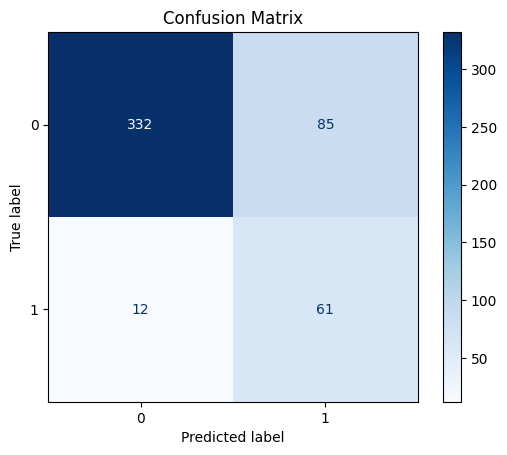

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

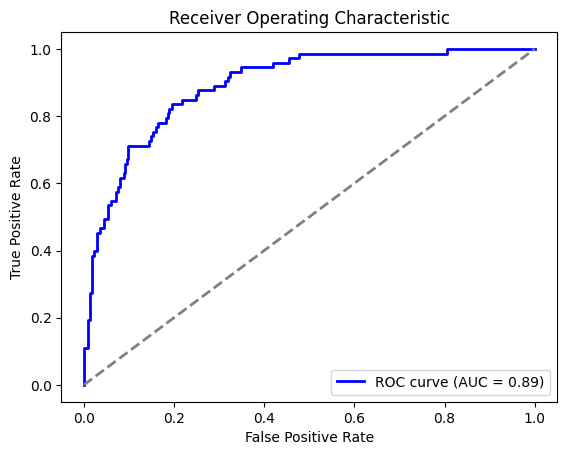

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(['anger', 'disgust', 'fear', 'joy', 'sadness']):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.3878
anger: Precision=0.1875, Recall=0.6000, F1=0.2857
disgust: Precision=0.2000, Recall=0.2000, F1=0.2000
fear: Precision=0.3235, Recall=0.9167, F1=0.4783
joy: Precision=0.5345, Recall=0.9688, F1=0.6889
sadness: Precision=0.4545, Recall=0.7895, F1=0.5769


In [ ]:
test_encodings = tokenizer(list(test_afr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_afr), 5)))  
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.1).numpy()

test_afr[['anger', 'disgust', 'fear', 'joy', 'sadness']] = test_predictions
test_afr.to_csv('test_predictions_afr_xlm_roberta_sentiment_v1.csv', index=False)